This Notebook presents the application of the Equivalent Layer technique using a regular-spaced grid of aeromagnetic data at Carajas, Para, Brazil. 

To achieve high efficiency in property estimative of the equivalent sources, the method CGLS for inversion was used, combined with a fast matrix-vector product only possible because of the Block-Toeplitz Toeplitz-Block(BTTB) structure of the sensitivity matrix. 

The total number of data is 7,706,153. For this case we gridded the data up to 2,500,00 observation points, which means that for storing the full sensitivity matrix it would be necessary 45.47 Terabytes of RAM. However, using the Toeplitz structure it is not necessary to store the whole matrix, but only the first column and first row of the first and last row of blocks of the matrix. Thus, the storage is reduced to 76.29 Megabytes.

This fast matrix-vector product also is used for data processing (upward continuation) in a very efficient way, making it possible to process 2,500,000 data in half a second.

### Import

In [1]:
import numpy as np
import functions_eq_mag as fc
import functions_fatiando as ft
from timeit import default_timer as time
from scipy.interpolate import griddata
from scipy import interpolate, signal
import pickle as pickle
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

### Observed Grid and Data

In [2]:
with open('carajas_tf_frontiers.pickle', 'rb') as r:
    carajas = pickle.load(r)

In [3]:
xi = carajas['x']
yi = carajas['y']
zi = carajas['z']
dobs = carajas['tf']
shape_m = (1000, 500)
N = shape_m[0]*shape_m[1]
xi_plot = carajas['x']/1000
yi_plot = carajas['y']/1000

In [18]:
print(np.min(carajas['z']), np.mean(carajas['z']), np.max(carajas['z']))

-900.0 -900.0 -900.0


### Plot the gridded data of Carajas, Brasil

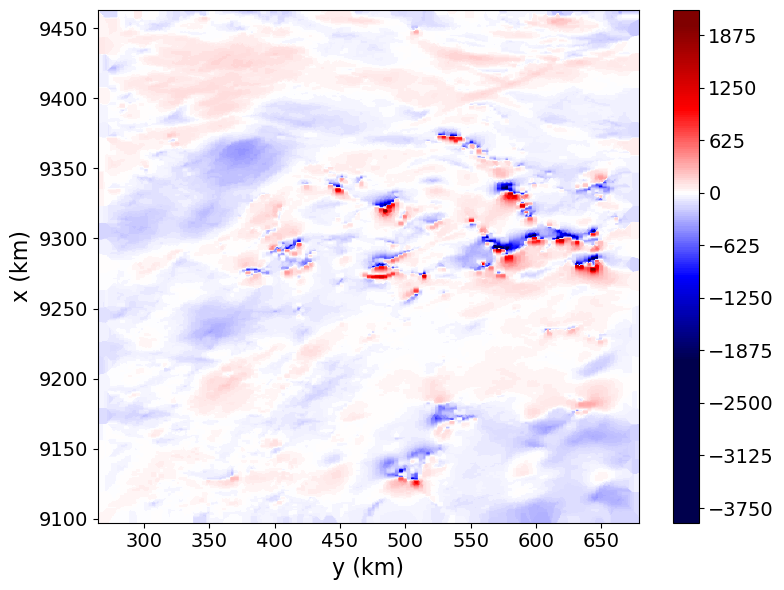

In [16]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_facecolor('xkcd:white')
#ranges_max = np.max(np.abs(dobs))
ranges_max = 2000
plt.tricontourf(yi_plot, xi_plot, dobs, 300, cmap='seismic',vmin=-ranges_max,vmax=ranges_max)
#cb = plt.colorbar(shrink=0.825)
cb = plt.colorbar()
plt.clim(-ranges_max, ranges_max)
cb.ax.tick_params(labelsize=14)
#plt.axis('scaled')
#cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('x (km)', fontsize=16)
plt.tight_layout()
plt.savefig('../../../manuscript/Fig/carajas_tf_real_data_1000x500.png', dpi=300)

## Equivalent layer Depth

In [5]:
# Equivalent Layer depth
zj = np.ones_like(zi) * 0

## Magnetic configuration

As this area is very large different values of the magnetic main field can be considered. 
The main field declination was calculated using the tool in the website (for the date 01/01/2014): https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml

When the latitude is -5° and longitude -53° the declination is -18.89°.

When the latitude is -8° and longitude -53° the declination is -18.97°.

When the latitude is -5° and longitude -50.5° the declination is -19.86°.

When the latitude is -8° and longitude -50.5° the declination is -20.04°.

For this test I considered an approximated mid location of the area (latitude -6.5° and longitude -50.75°). The declinations is -19.48°.

The inclination was calculated considering the Geocentric axial dipole model ($tang \, I = 2 \times tan \, \lambda$).

The source magnetization is unknown. Inclination and declination equal to the main field is being used.

In [6]:
#inc0 = np.rad2deg(np.arctan(2*np.tan(np.deg2rad(6.5))))
inc0 = -7.43915

In [7]:
# Magnetic Configuration
inc0 = np.deg2rad(inc0)
dec0 = np.deg2rad(-19.48)
inc = np.deg2rad(inc0)
dec = np.deg2rad(-19.48)

# Main field magnetization cosines direction
F = np.array([np.cos(inc0) * np.cos(dec0), np.cos(inc0) * np.sin(dec0), np.sin(inc0)])

# Equivalent sources magnetization cosines direction
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

## Convolutional equivalent layer

In [8]:
w = time()
itmax = 200
p_cgls, dobs_cgls = fc.cgls_eq_bccb_mag(xi, yi, zi, zj, shape_m, dobs, F, h, itmax)
t = time()
tcpu = t - w
print (tcpu)

29.81671173900031


## Deconvolutional equivalent layer

In [9]:
w = time()
mu = 10**(-16)
p_cgls_ced, dobs_cgls_dec = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape_m,dobs,mu)
t = time()
tcpu = t - w
print (tcpu)

0.32903450000230805


## Data, Predicted data and Residuals plot

## Fast Equivalent layer BCCB plot

In [10]:
delta_dobs = dobs_cgls - dobs
mean = np.mean(delta_dobs)
print (mean)
std = np.std(delta_dobs)
print (std)

-0.06404347121631458
1.9687559764381535


In [11]:
delta_dobs_dec = dobs_cgls_dec - dobs
mean = np.mean(np.abs(delta_dobs_dec))
print (mean)
std = np.std(np.abs(delta_dobs_dec))
print (std)

18.99292171867934
33.64119902092593


## Transformations comparison - Upward continuation

In [12]:
z_up = np.ones_like(xi) * -3500

hxx,hxy,hxz,hyy,hyz,hzz = fc.h_bttb_mag(xi,yi,z_up,zj,F,h,shape_m)
cev = fc.ones_cev_mag(hxx,hxy,hxz,hyy,hyz,hzz,shape_m,N,F,h)

tf_conv_up = fc.fast_forward_bccb_mag(cev,p_cgls,shape_m,N)
tf_deconv_up = fc.fast_forward_bccb_mag(cev,p_cgls_ced,shape_m,N)

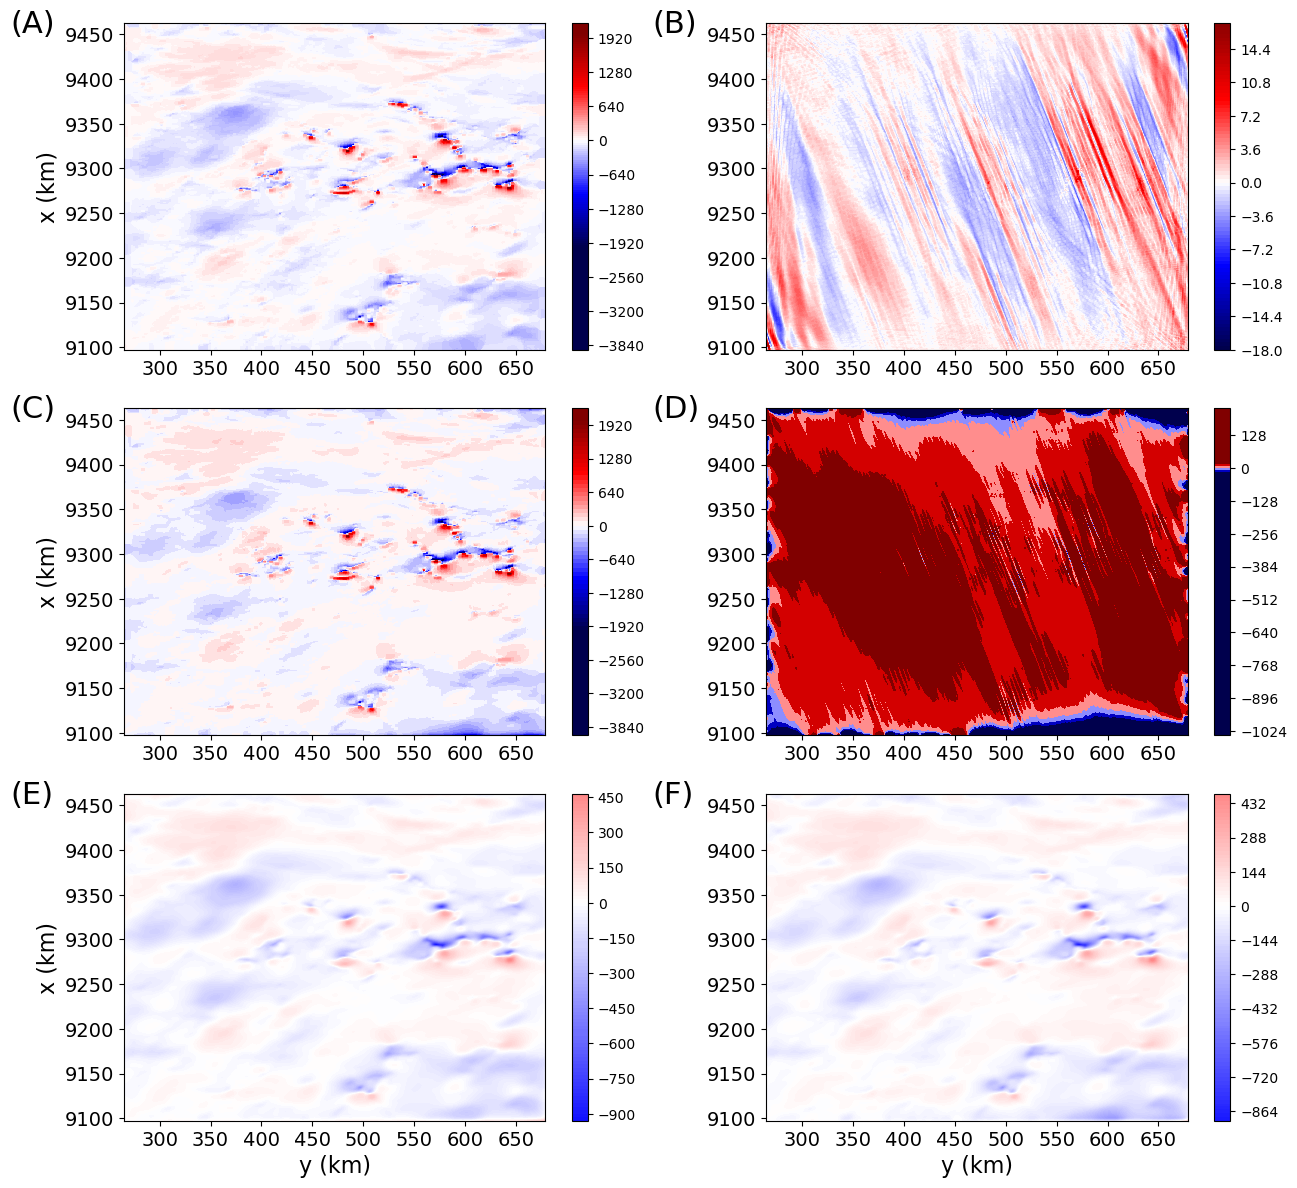

In [17]:
# plot of the total field anomaly at z=900 
fig = plt.figure(figsize=(13, 12))
fig.patch.set_facecolor('xkcd:white')

ranges_res = np.max(np.abs(delta_dobs))

plt.subplot(321)
#plt.title('Convolutional method', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, dobs_cgls, 200, cmap='seismic',vmin=-ranges_max,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(-ranges_max, ranges_max)
#cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(A)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(322)
#plt.title('Convolutional method residual', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, delta_dobs, 100, cmap='seismic',vmin=-ranges_res,vmax=ranges_res)
cb = plt.colorbar()
plt.clim(-ranges_res, ranges_res)
#cb.set_label('$residual$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.annotate(text='(B)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(323)
#plt.title('Deconvolutional method', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, dobs_cgls_dec, 100, cmap='seismic',vmin=-ranges_max,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(-ranges_max, ranges_max)
#cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(C)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(324)
#plt.title('Deconvolutional method residual', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, delta_dobs_dec, 200, cmap='seismic',vmin=-ranges_res,vmax=ranges_res)
cb = plt.colorbar()
plt.clim(-ranges_res, ranges_res)
#cb.set_label('$residual$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.annotate(text='(D)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(325)
#plt.title('Convolutional upward continuation', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, tf_conv_up, 100, cmap='seismic',vmin=-ranges_max,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(-ranges_max, ranges_max)
#cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(E)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(326)
#plt.title('Deconvolutional upward continuation \u03BC = $10^{-16}$', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, tf_deconv_up, 200, cmap='seismic',vmin=-ranges_max,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(-ranges_max, ranges_max)
#cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y (km)', fontsize=16)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.annotate(text='(F)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.tight_layout()
plt.savefig('../../../manuscript/Fig/carajas_tf_predito_1000x500.png', dpi=300)